# <span style="color:red"> NSL Esercitazione 8 </span>
### <span style="color:pink">  Giacomo Boringhieri 13457A</span>

L’obiettivo di questa esercitazione è realizzare l’algoritmo del **Simulated Annealing** e applicarlo a un sistema quantistico.

Si studia una particella quantistica confinata in una dimensione, soggetta a un potenziale simmetrico:  
$$
V(x) = x^4 - \tfrac{5}{2}x^2.
$$  

Poiché il problema non ammette una soluzione analitica esatta, si utilizza il **metodo variazionale** per stimare l’energia dello stato fondamentale $E_0$. Questo approccio consiste nell’ottimizzare una funzione d’onda di prova dipendente da alcuni parametri.

Una possibile opzione è considerare la combinazione simmetrica di due gaussiane centrate in $\pm \mu$, con larghezza determinata dal parametro $\sigma$:  
$$
\Psi_T^{\sigma,\mu}(x) \propto e^{-\frac{(x-\mu)^2}{2\sigma^2}} + e^{-\frac{(x+\mu)^2}{2\sigma^2}}.
$$  

I parametri variazionali $\sigma$ (che controlla la dispersione) e $\mu$ (che fissa la posizione dei picchi) devono essere regolati in modo da minimizzare il valore atteso dell’hamiltoniana $\langle \hat{H} \rangle_T$, il quale, in base al principio variazionale, fornisce sempre una stima superiore o uguale a $E_0$.

Chiaramente quella che stiamo andando a cercare in questo modo è la miglior configurazione di paramentri di questa funzione d'onda test con doppio picco gaussiano, non il vero groud state dell'Hamiltoniana. Non dovremo quindi stupirci se troveremo un'energia meno bassa di quella del vero groud state.

## <span style="color:blue">  Esercizio 8.1</span>

Si è sviluppato un codice di **Monte Carlo Variazionale (VMC)** per analizzare il comportamento di una particella quantistica in una dimensione. L'approccio utilizza l'**algoritmo di Metropolis** per generare configurazioni distribuite secondo il modulo quadro di una funzione d'onda trial, $|\Psi_T^{\sigma,\mu}(x)|^2$, impiegando una **distribuzione di proposta uniforme** $T(x_{\rm nuovo}|x_{\rm vecchio})$.

Per ottenere una stima dell'energia dello stato fondamentale, è stato applicato il **metodo del data blocking**, calcolando il valore medio dell'Hamiltoniana secondo:

$$
\langle \hat{H} \rangle_T = 
\frac{\int dx \Psi_T^*(x) \hat{H} \Psi_T(x)}{\int dx |\Psi_T(x)|^2} =
\int dx \frac{|\Psi_T(x)|^2}{\int dx |\Psi_T(x)|^2} \frac{\hat{H} \Psi_T(x)}{\Psi_T(x)}.
$$

Tutte le simulazioni sono state condotte in **unità naturali**, con $\hbar = 1$ e $m = 1$. La componente di energia cinetica è stata calcolata **analiticamente** attraverso:

$$
\frac{-\frac{\hbar^2}{2m} \frac{\partial^2}{\partial x^2} \Psi_T^{\sigma,\mu}(x)}{\Psi_T^{\sigma,\mu}(x)}.
$$

L'**algoritmo di Metropolis** permette di campionare la distribuzione $|\Psi_T^{\sigma,\mu}(x)|^2$, generando una catena di Markov di posizioni che converge alla distribuzione di equilibrio senza necessità di conoscere la costante di normalizzazione.  

Ad ogni passo, si propone una nuova posizione $y$ a partire dall'attuale $x$, aggiungendo uno spostamento casuale estratto da una **distribuzione uniforme simmetrica**. La proposta viene accettata con probabilità:

$$
A(x \to y) = \min \left(1, \frac{|\Psi_T^{\sigma,\mu}(y)|^2}{|\Psi_T^{\sigma,\mu}(x)|^2}\right).
$$

Successivamente, tramite la tecnica del **data blocking**, ho stimato il valore medio dell’energia corrispondente alla funzione d’onda con i parametri variazionali scelti, in questo caso $\sigma = 1.0$ e $\mu = 0.5$.  

Di seguito mostro i grafici relativi all’andamento dell’accettanza e della stima dell’energia in funzione del numero di blocchi.

Riporto anche l'accettazione metropolis media dei vari blocchi

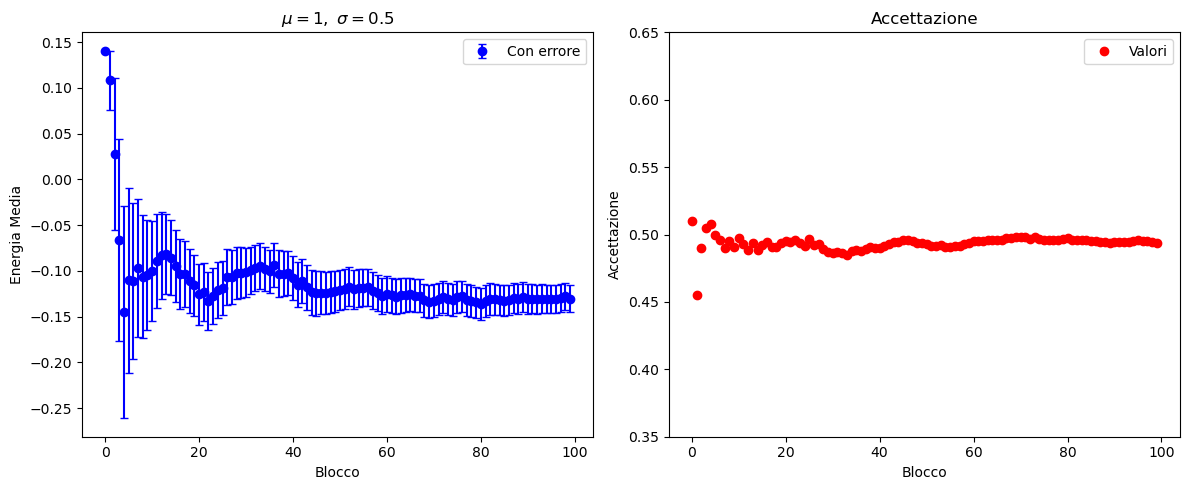

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Carica i dati
data = np.loadtxt("OUTPUT/initial_energy.dat")

# Estrai le colonne
x = data[:, 0]            # colonna 1 (indice 0)
y = data[:, 1]            # colonna 2 (indice 1)
y_err = data[:, 2]        # colonna 3 (indice 2)
y_values = data[:, 4]     # colonna 4 (indice 3)

# Crea la figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Primo plot: con errore
axes[0].errorbar(x, y, yerr=y_err, fmt='o', capsize=3, color='blue', label='Con errore')
axes[0].set_xlabel('Blocco')
axes[0].set_ylabel('Energia Media')
axes[0].set_title(r'$\mu = 1, \ \sigma = 0.5$')
axes[0].legend()

# Secondo plot: solo valori, punti non collegati
axes[1].plot(x, y_values, 'o', color='red', label='Valori')
axes[1].set_xlabel('Blocco')
axes[1].set_ylabel('Accettazione')
axes[1].set_title('Accettazione')
axes[1].set_ylim(0.35, 0.65)
axes[1].legend()

plt.tight_layout()
plt.show()

Nella stima dell'integrale ho scelto uno step del Metropolis che mi consentisse di mantanere un'accettazione media intorno al 50%
Per fare soddisfare sempre questa condizione ho implementato un metodo che modifica lo step del metropolis per mantenere l'accettazone al 50%

## <span style="color:blue">  Esercizio 8.2</span>

In questo secondo esercizio ho utilizzato la classe definita nell’8.1 per determinare i valori ottimali dei parametri variazionali associati alla funzione d’onda di prova $\Psi_T^{\sigma,\mu}(x)$ nello stato fondamentale.

A tal fine è stato impiegato l’algoritmo di ottimizzazione *Simulated Annealing*, che riproduce il comportamento di un metallo portato ad alta temperatura e poi raffreddato **gradualmente**. Se il raffreddamento avviene troppo in fretta, il sistema si blocca in un minimo locale (un solido con molti difetti). Al contrario, un raffreddamento lento permette agli atomi di disporsi in un reticolo regolare, raggiungendo così il minimo globale (struttura cristallina).

L’algoritmo di Metropolis si adatta bene a questo scopo: la probabilità di accettare una configurazione di energia maggiore è
$$
p(\Delta E) \propto \exp\!\left(-\frac{\Delta E}{T}\right).
$$  
Quando la temperatura è elevata, il sistema accetta con buona probabilità configurazioni peggiori, esplorando a fondo lo spazio dei parametri. Con il progressivo abbassamento della temperatura, invece, tende ad accettare quasi esclusivamente configurazioni migliori.

Il primo grafico mostra l’evoluzione di $\mu$ e $\sigma$ nello spazio dei parametri al variare della temperatura. Si osserva chiaramente che, man mano che il sistema si raffredda, la varietà delle configurazioni tende a ridursi.

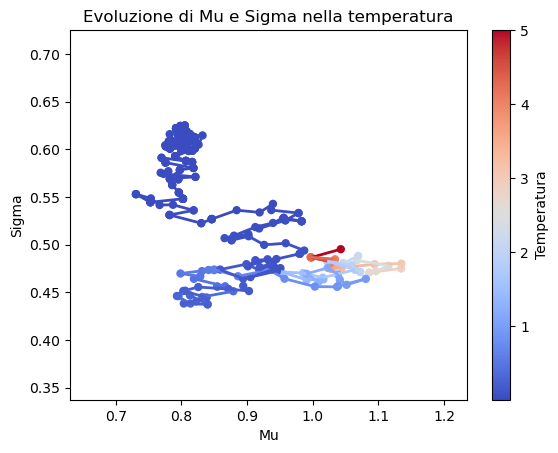

Ultimi valori: Mu = 0.798448, Sigma = 0.624390


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

# Carica i dati
data = np.loadtxt("OUTPUT/sa_trajectory.dat")
mu = data[:, 2]
sigma = data[:, 3]

# Array tempo
temp = data[:,1]

# Creiamo segmenti per la linea colorata
points = np.array([mu, sigma]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Crea la LineCollection colorata
lc = LineCollection(segments, cmap='coolwarm', norm=plt.Normalize(temp.min(), temp.max()))
lc.set_array(temp)
lc.set_linewidth(2)

fig, ax = plt.subplots()
ax.add_collection(lc)
ax.scatter(mu, sigma, c=temp, cmap='coolwarm', s=25)  # punti per evidenziare
plt.colorbar(lc, label='Temperatura')
ax.set_xlabel('Mu')
ax.set_ylabel('Sigma')
ax.set_title('Evoluzione di Mu e Sigma nella temperatura')
ax.set_xlim(mu.min() - 0.1, mu.max() + 0.1)
ax.set_ylim(sigma.min() - 0.1, sigma.max() + 0.1)
plt.show()

# Stampa a video gli ultimi valori
print(f"Ultimi valori: Mu = {mu[-1]:.6f}, Sigma = {sigma[-1]:.6f}")

Ora che abbiamo trovato la miglior configurazine di parametri eseguo una simulazione mirata, analoga a quella dell'esercizo 8.1, per trovare energia, e relativa incertezza, di questa funzione d'onda ottimizzata

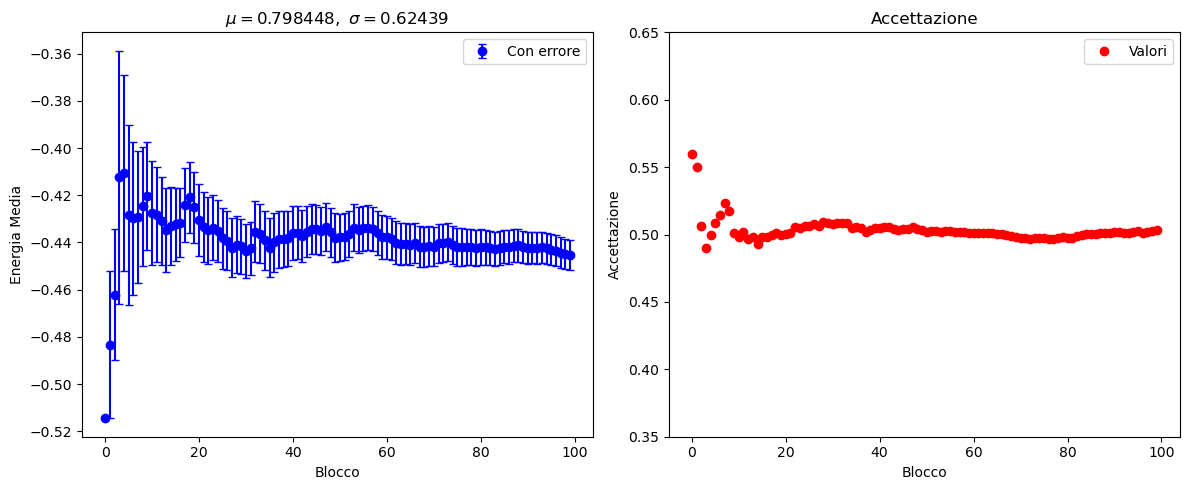

Ultimo valore: E = -0.445246 ± 0.006363


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Carica i dati
data = np.loadtxt("OUTPUT/block_energies.dat")

# Estrai le colonne
x = data[:, 0]            # colonna 1 (indice 0)
y = data[:, 1]            # colonna 2 (indice 1)
y_err = data[:, 2]        # colonna 3 (indice 2)
y_values = data[:, 4]     # colonna 4 (indice 3)

# Crea la figura con due subplot affiancati
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Primo plot: con errore
axes[0].errorbar(x, y, yerr=y_err, fmt='o', capsize=3, color='blue', label='Con errore')
axes[0].set_xlabel('Blocco')
axes[0].set_ylabel('Energia Media')
axes[0].set_title(rf'$\mu = {mu[-1]}, \ \sigma = {sigma[-1]}$')
axes[0].legend()

# Secondo plot: solo valori, punti non collegati
axes[1].plot(x, y_values, 'o', color='red', label='Valori')
axes[1].set_xlabel('Blocco')
axes[1].set_ylabel('Accettazione')
axes[1].set_title('Accettazione')
axes[1].set_ylim(0.35, 0.65)
axes[1].legend()

plt.tight_layout()
plt.show()

# Stampa a video gli ultimi valori enegia
print(f"Ultimo valore: E = {y[-1]:.6f} ± {y_err[-1]:.6f}")


Mostro anche l'istogramma per la forma del modulo quadro della funzione d'onda

Ground state energy matrix:  -0.4604658796926825


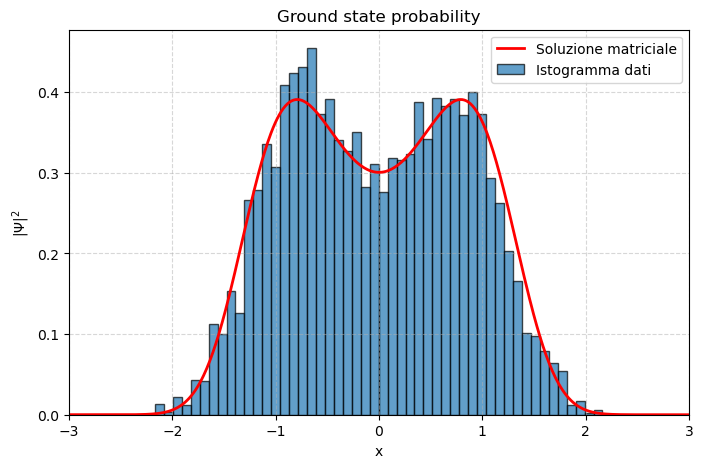

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# --- Carica dati istogramma ---
data = np.loadtxt("OUTPUT/psi_histogram.dat")
x_data = data[:,0]
y_data = data[:,1]

# --- Parametri fisici e numerici ---
hbar = 1
m = 1
a = 10      # intervallo [-a/2, a/2]
N = 1000    # numero di punti griglia

# Griglia x per la soluzione matriciale
x = np.linspace(-a/2, a/2, N)
dx = x[1] - x[0]

# --- Potenziale ---
def Vpot(x):
    return (x**2 - 2.5)*x**2
V = Vpot(x)

# --- Derivata seconda con differenze centrali ---
CDiff = np.diag(np.ones(N-1), -1) - 2*np.diag(np.ones(N),0) + np.diag(np.ones(N-1),1)

# --- Hamiltoniana ---
H = -(hbar**2)/(2*m*dx**2) * CDiff + np.diag(V)

# --- Autovalori e autovettori ---
E, psi = np.linalg.eigh(H)

# Trasposta e normalizzazione rispetto a dx
psi = np.transpose(psi)
psi = psi / np.sqrt(np.sum(psi**2, axis=1) * dx)

print("Ground state energy matrix: ", E[0])

# --- Plot ---
plt.figure(figsize=(8,5))

# Soluzione matriciale del ground state
plt.plot(x, psi[0]**2, 'r-', lw=2, label="Soluzione matriciale")

# Istogramma dei dati
plt.bar(x_data, y_data, width=(x_data[1]-x_data[0]), alpha=0.7, label="Istogramma dati", edgecolor="black")

plt.title("Ground state probability")
plt.xlabel("x")
plt.ylabel(r"$|\Psi|^2$")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.5)
plt.xlim((-3,3))
plt.show()